Data loaded successfully.
Starting preprocessing...
Data shape after preprocessing: (2919, 230)
Starting model training...
--- Fold 1 ---
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1

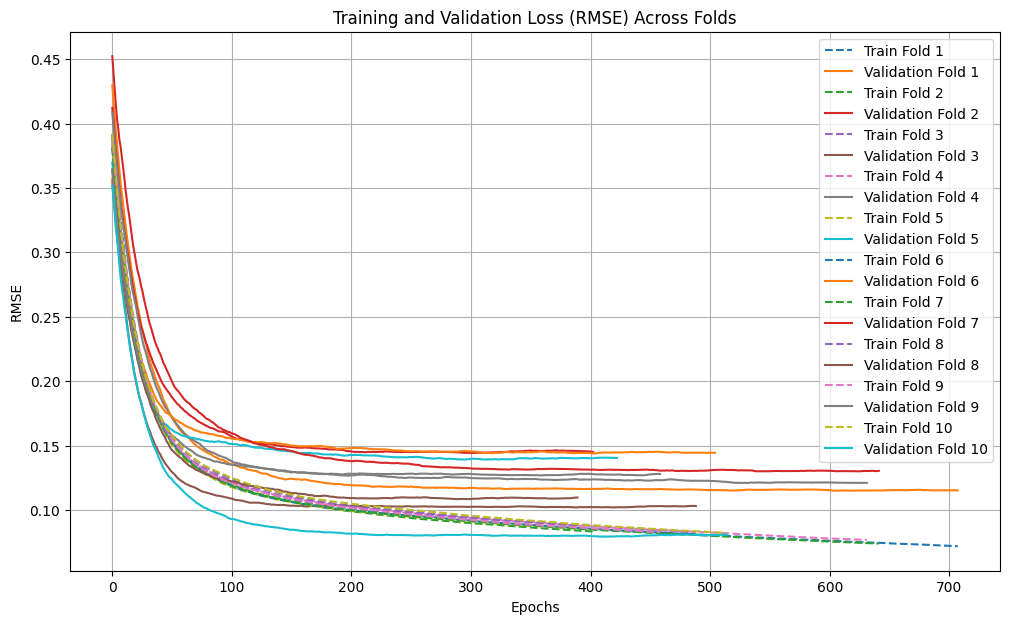


--- Model Evaluation ---
Average Cross-Validation RMSE: 0.1210
This is the expected RMSE on the log-transformed SalePrice.
--------------------------
Model training complete.
Submission file 'submission.csv' created successfully.
     Id      SalePrice
0  1461  122963.780447
1  1462  157595.913229
2  1463  183413.098795
3  1464  194245.322963
4  1465  192802.602802


In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from scipy.stats import skew

# Add a note for the user about a required library
print("Note: This script uses XGBoost. If you don't have it, please install it using: pip install xgboost")


# --- 1. Data Loading ---
def load_data():
    """Loads the training and testing datasets."""
    try:
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
        print("Data loaded successfully.")
        return train_df, test_df
    except FileNotFoundError:
        print("Error: train.csv or test.csv not found.")
        print("Please ensure the data files are in the same directory as the script.")
        return None, None

# --- 2. Preprocessing and Feature Engineering (IMPROVED) ---
def preprocess(train_df, test_df):
    """Handles missing values, outliers, feature engineering, and data transformation."""
    print("Starting improved preprocessing...")

    # Store test IDs for submission file and drop Id columns
    test_ids = test_df['Id']
    train_df = train_df.drop('Id', axis=1)
    test_df = test_df.drop('Id', axis=1)

    # --- 1. Outlier Removal (IMPROVEMENT) ---
    # Based on common practice for this dataset, we remove a few extreme outliers.
    train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)
    print(f"Removed outliers. New train shape: {train_df.shape}")


    # --- 2. Target Transformation ---
    # Log transform the target variable to handle its skewness
    train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
    y = train_df['SalePrice']


    # --- 3. Combine Data and Handle Missing Values ---
    # Combine train and test data for consistent preprocessing
    all_data = pd.concat((train_df.drop('SalePrice', axis=1), test_df))
    print(f"Combined data shape: {all_data.shape}")

    # Fill missing values based on data description
    for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
                'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
        all_data[col] = all_data[col].fillna('None')

    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
                'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
        all_data[col] = all_data[col].fillna(0)

    # Use mode for features where it makes sense
    for col in ('MSZoning', 'Utilities', 'Functional', 'Exterior1st', 'Exterior2nd',
                'KitchenQual', 'SaleType', 'Electrical'):
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

    # LotFrontage: Fill with the median of the neighborhood (group-wise imputation)
    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median()))


    # --- 4. Feature Engineering (IMPROVEMENT) ---
    print("Creating new features...")
    # More comprehensive features
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
    all_data['Total_Bathrooms'] = (all_data['FullBath'] + 0.5 * all_data['HalfBath'] +
                                   all_data['BsmtFullBath'] + 0.5 * all_data['BsmtHalfBath'])
    all_data['Total_Porch_SF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                                  all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                                  all_data['WoodDeckSF'])
    # Age related features
    all_data['YearBuilt_Age'] = all_data['YrSold'] - all_data['YearBuilt']
    all_data['YearRemod_Age'] = all_data['YrSold'] - all_data['YearRemodAdd']
    
    # Simplified quality/existence indicators
    all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


    # --- 5. Fix Skewed Features (IMPROVEMENT) ---
    # Find numeric features and calculate their skewness
    numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
    skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))
    skewed_feats = skewed_feats[skewed_feats > 0.75] # Common threshold for skewness
    skewed_feats = skewed_feats.index
    # Apply log transformation to fix skewness
    all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
    print(f"Applied log transformation to {len(skewed_feats)} skewed features.")


    # --- 6. Encoding Categorical Features ---
    # Using pandas get_dummies is a robust way to handle this
    all_data = pd.get_dummies(all_data)


    # Final preparation for modeling
    X = all_data[:len(y)]
    X_test = all_data[len(y):]

    print(f"Preprocessing complete. Final data shape: X={X.shape}, X_test={X_test.shape}")
    return X, y, X_test, test_ids

# --- 3. Model Training (IMPROVED with Blending) ---
def train_and_predict(X, y, X_test):
    """Trains LightGBM and XGBoost models and blends their predictions."""
    print("Starting model training with K-Fold cross-validation...")

    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # --- Initialize arrays for predictions ---
    lgb_predictions = np.zeros(X_test.shape[0])
    xgb_predictions = np.zeros(X_test.shape[0])
    oof_rmse_scores = [] # Out-of-fold RMSE scores

    # --- K-Fold Training Loop ---
    for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
        print(f"--- Fold {fold+1}/10 ---")
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # --- a) LightGBM Model ---
        lgb_model = lgb.LGBMRegressor(
            objective='regression',
            metric='rmse',
            n_estimators=2000,
            learning_rate=0.01,
            feature_fraction=0.8,
            bagging_fraction=0.8,
            bagging_freq=1,
            lambda_l1=0.1,
            lambda_l2=0.1,
            num_leaves=31,
            verbose=-1,
            n_jobs=-1,
            seed=42
        )
        lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                      eval_metric='rmse', callbacks=[lgb.early_stopping(100, verbose=False)])
        lgb_predictions += lgb_model.predict(X_test) / kf.n_splits

        # --- b) XGBoost Model ---
        xgb_model = xgb.XGBRegressor(
            objective='reg:squarederror',
            eval_metric='rmse',
            n_estimators=2000,
            learning_rate=0.01,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
        xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                      early_stopping_rounds=100, verbose=False)
        xgb_predictions += xgb_model.predict(X_test) / kf.n_splits

        # --- c) Evaluate fold performance on a blend of OOF predictions ---
        # Get out-of-fold predictions for this fold
        val_preds_lgb = lgb_model.predict(X_val)
        val_preds_xgb = xgb_model.predict(X_val)
        # Blend the validation predictions to estimate the final blend's performance
        blended_val_preds = 0.7 * val_preds_lgb + 0.3 * val_preds_xgb
        fold_rmse = np.sqrt(mean_squared_error(y_val, blended_val_preds))
        oof_rmse_scores.append(fold_rmse)
        print(f"Fold {fold+1} Blended RMSE: {fold_rmse:.5f}")

    # --- Final Evaluation and Prediction Blending ---
    mean_rmse = np.mean(oof_rmse_scores)
    print("\n--- Model Evaluation ---")
    print(f"Average Cross-Validation Blended RMSE: {mean_rmse:.5f}")
    print("--------------------------")

    # Blend the final test predictions
    # The weights (0.7, 0.3) can be tuned as a hyperparameter as well.
    blended_predictions = 0.7 * lgb_predictions + 0.3 * xgb_predictions
    print("Model training and blending complete.")
    return blended_predictions


# --- 4. Create Submission File ---
def create_submission(test_ids, predictions):
    """Creates the submission file in the required format."""
    # Reverse the log transformation to get the actual sale prices
    final_predictions = np.expm1(predictions)

    submission = pd.DataFrame({
        "Id": test_ids,
        "SalePrice": final_predictions
    })
    submission.to_csv('submission.csv', index=False)
    print("\nSubmission file 'submission.csv' created successfully.")
    print(submission.head())


# --- Main Execution ---
if __name__ == '__main__':
    train_df, test_df = load_data()
    if train_df is not None and test_df is not None:
        X, y, X_test, test_ids = preprocess(train_df, test_df)
        predictions = train_and_predict(X, y, X_test)
        create_submission(test_ids, predictions)